Your company, DS Pros, would like to win a contract with a big city council as it would give us great PR. To do so you think it would be a great idea to proactively browse in the open data sets of this city (the one you choose, total freedom here) identify a situation that could be solved or improved using classification or regression algorithms (you can use unsupervised algorithms to build a semisupervised pipeline) and present it to the technical office of that city council.

You need to prepare the following:

**A presentation describing the solution you try to solve, how classification will solve it and a summary of the solution proposed
A well documented and visually appealing notebook where you try different models, explain the steps followed and chose one particular algorithm and hyperparameters (explaining why)
You should also export that model, once trained, using pickle or similar so it can be reused.
You should implement a .py script that loads the exported model, accepts a file with samples to classify (identified with an id) and stores the results in a DDBB table (duckdb) with fields id and predicted value.
You should provide the files to test the .py script and clear instructions on how to run it.
Only code, functions, libraries, etc used in class can be used. If I don't recognise it, I will consider that part does not exist.
If you don't find yourself confident with the .py and the sql part you can do just a presentation and a notebook (you still have to provide the source data so I can test everything). In this case maximum grade will be 79. But remember that if the .py or sql part does not work the grade can go down to 0.**


Happy coding!!

In [ ]:
import pandas as pd #The teacher prefer that we stick to what we have seen in class 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns        
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_parquet('yellow_tripdata_2025-02.parquet')

In [4]:
print(df.shape)
df.head()
df.info()

(3577543, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577543 entries, 0 to 3577542
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_

In [5]:
# 2.1 Create target
df["duration"] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60
df = df[(df.duration > 1) & (df.duration < 120)]  # drop outliers
# 2.2 For classification:
df["long_trip"] = (df.duration > 30).astype(int)

In [6]:
# notebook: cells 5–8
# 3.1 Extract datetime features
df["pickup_hour"] = df.tpep_pickup_datetime.dt.hour
df["pickup_wday"] = df.tpep_pickup_datetime.dt.weekday

# 3.2 Select features & train/test split
features = ["trip_distance", "passenger_count", "pickup_hour", "pickup_wday"]
X = df[features]
y_reg = df["duration"]
y_clf = df["long_trip"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_clf, test_size=0.2, random_state=42
)


In [8]:
# notebook: cells 9–11 (updated)

from sklearn.ensemble import (
    HistGradientBoostingRegressor,
    HistGradientBoostingClassifier
)
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    roc_auc_score
)

# 4.1 Regression baseline with native NaN support
hgr = HistGradientBoostingRegressor(random_state=42)
hgr.fit(X_train, y_reg.loc[X_train.index])
y_pred_reg = hgr.predict(X_test)
print("HGB Regressor RMSE:", np.sqrt(mean_squared_error(y_reg.loc[X_test.index], y_pred_reg)))

# 4.2 Classification baseline with native NaN support
hgc = HistGradientBoostingClassifier(random_state=42)
hgc.fit(X_train, y_train)
y_pred = hgc.predict(X_test)
print("HGB Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("HGB Classifier AUC:", roc_auc_score(y_test, hgc.predict_proba(X_test)[:,1]))


HGB Regressor RMSE: 5.617140261417127
HGB Classifier Accuracy: 0.955727302816762
HGB Classifier AUC: 0.9654065749500496


Dataset shape: (3577543, 20)

Data types:
VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
cbd_congestion_fee              float64
dtype: object

Summary statistics:
           VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  3.577543e+06                     3577

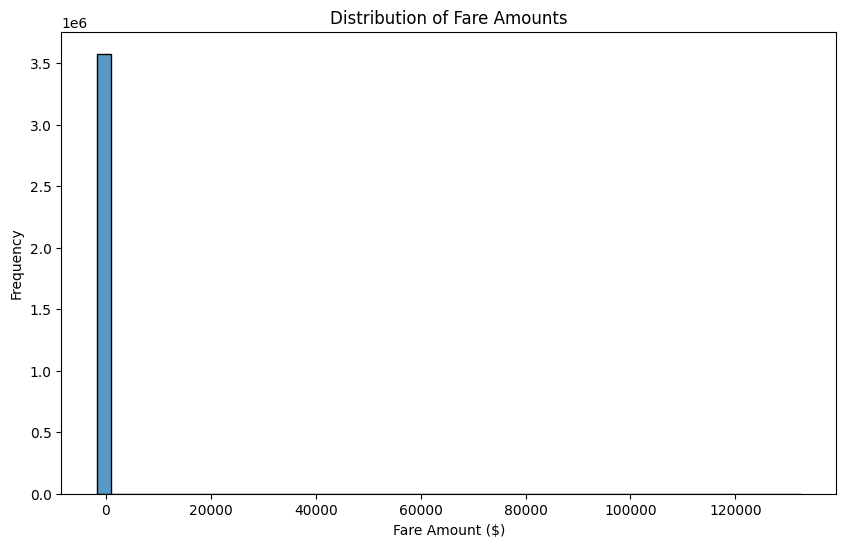

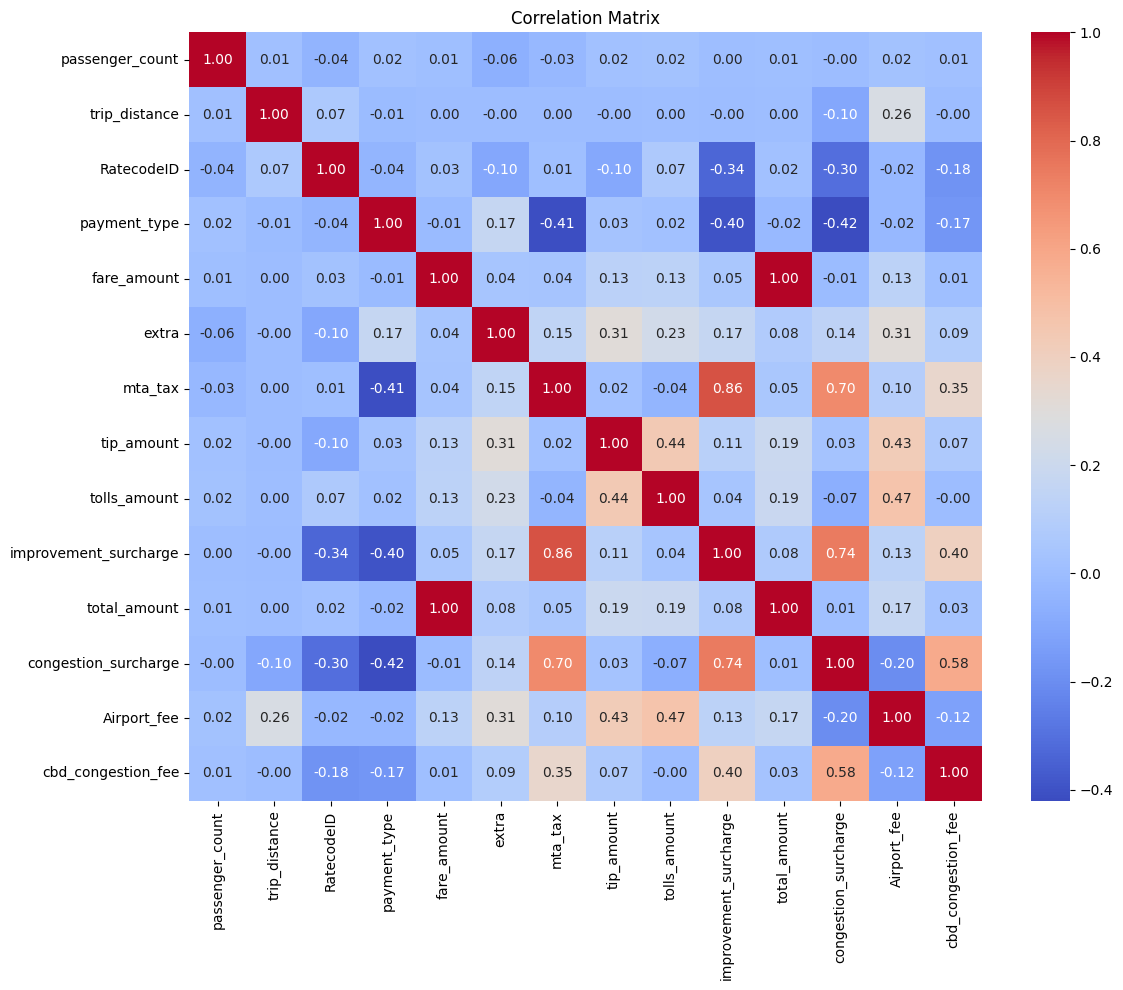

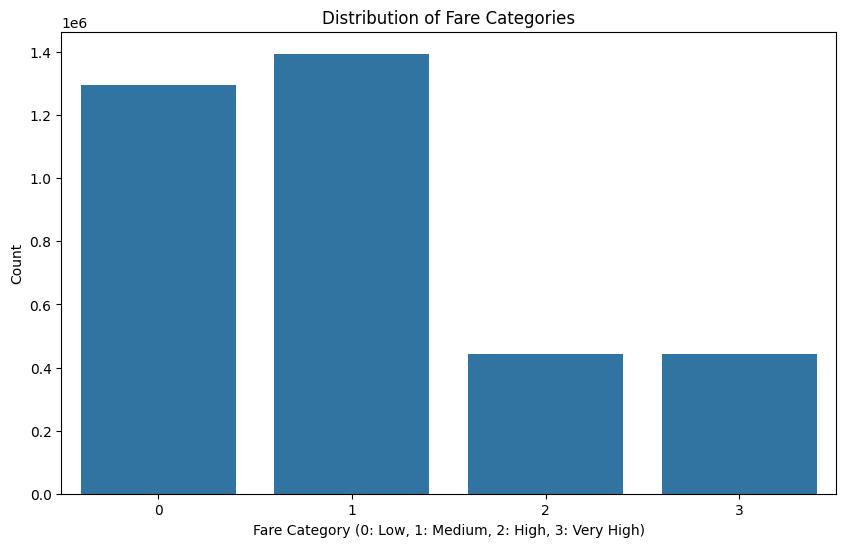

Training set shape: (2862034, 6)
Testing set shape: (715509, 6)
Fare category distribution in training set:
fare_category
1    0.389852
0    0.362420
2    0.124041
3    0.123687
Name: proportion, dtype: float64
Training Random Forest...
Random Forest Accuracy: 0.8549
              precision    recall  f1-score   support

           0       0.89      0.85      0.87    259072
           1       0.86      0.89      0.88    279203
           2       0.74      0.73      0.73     88774
           3       0.86      0.87      0.87     88460

    accuracy                           0.85    715509
   macro avg       0.84      0.84      0.84    715509
weighted avg       0.86      0.85      0.85    715509

--------------------------------------------------
Training Gradient Boosting...
Gradient Boosting Accuracy: 0.8752
              precision    recall  f1-score   support

           0       0.92      0.86      0.89    259072
           1       0.87      0.91      0.89    279203
           2      

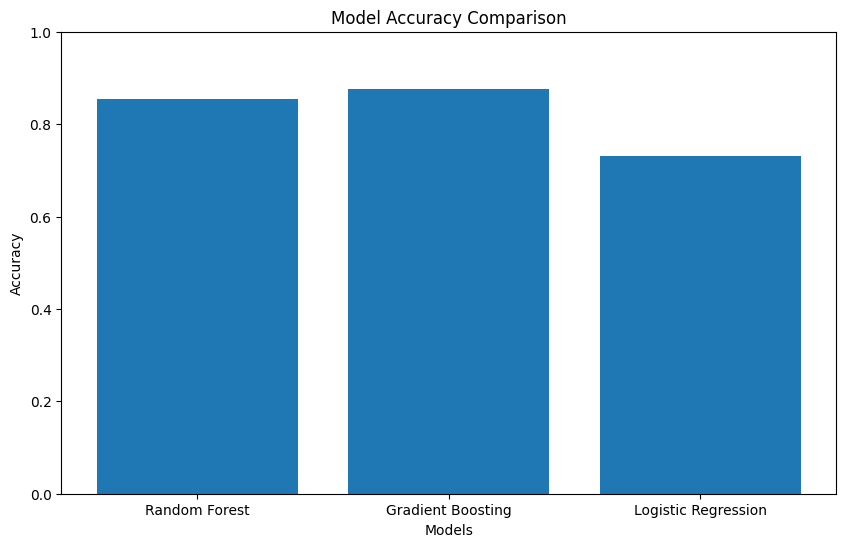

Best model: Gradient Boosting with accuracy 0.8752
Model has been exported to taxi_fare_classifier.pkl
Test samples saved to test_samples.csv


In [1]:
# Taxi Fare Prediction - Classification Approach
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import pickle
import warnings
warnings.filterwarnings('ignore')

# 1. Load the dataset
df = pd.read_parquet('yellow_tripdata_2025-02.parquet')

# 2. Exploratory Data Analysis
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

# Display first few rows
print("\nSample data:")
print(df.head())

# 3. Data Visualizations
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=50)
plt.title('Distribution of Fare Amounts')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation = numeric_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# 4. Feature Engineering
# Create fare categories for classification
def categorize_fare(fare):
    if fare <= 10:
        return 0  # Low fare
    elif fare <= 20:
        return 1  # Medium fare
    elif fare <= 30:
        return 2  # High fare
    else:
        return 3  # Very high fare

df['fare_category'] = df['fare_amount'].apply(categorize_fare)

# Distribution of fare categories
plt.figure(figsize=(10, 6))
sns.countplot(x='fare_category', data=df)
plt.title('Distribution of Fare Categories')
plt.xlabel('Fare Category (0: Low, 1: Medium, 2: High, 3: Very High)')
plt.ylabel('Count')
plt.show()

# Create time-based features
df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

# Extract time features
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month

# Calculate trip distance if not available
if 'trip_distance' not in df.columns:
    # Using Haversine formula to calculate distance
    from math import radians, cos, sin, asin, sqrt
    
    def haversine(lon1, lat1, lon2, lat2):
        # Convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        r = 6371  # Radius of Earth in kilometers
        return c * r
    
    df['calculated_distance'] = df.apply(
        lambda x: haversine(
            x['pickup_longitude'], 
            x['pickup_latitude'], 
            x['dropoff_longitude'], 
            x['dropoff_latitude']
        ) if all(pd.notna([
            x['pickup_longitude'], 
            x['pickup_latitude'], 
            x['dropoff_longitude'], 
            x['dropoff_latitude']
        ])) else np.nan, 
        axis=1
    )
    
    distance_feature = 'calculated_distance'
else:
    distance_feature = 'trip_distance'

# 5. Data Preprocessing
# Select features for model
features = [
    distance_feature,
    'passenger_count',
    'hour_of_day',
    'day_of_week',
    'month',
    'trip_duration'
]

# Handle potential missing values in selected features
for feature in features:
    if feature in df.columns and df[feature].isnull().sum() > 0:
        if df[feature].dtype in ['int64', 'float64']:
            df[feature] = df[feature].fillna(df[feature].median())
        else:
            df[feature] = df[feature].fillna(df[feature].mode()[0])

# Select rows with valid features and target
X = df[features].copy()
y = df['fare_category'].copy()

# Clean data - remove NaNs
valid_indices = ~(X.isnull().any(axis=1) | pd.isnull(y))
X = X[valid_indices]
y = y[valid_indices]

# 6. Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Fare category distribution in training set:")
print(y_train.value_counts(normalize=True))

# 7. Build preprocessing pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features)
    ]
)

# 8. Model Training and Comparison

# Pipeline for Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Pipeline for Gradient Boosting
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Pipeline for Logistic Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train and evaluate models
models = {
    'Random Forest': rf_pipeline,
    'Gradient Boosting': gb_pipeline,
    'Logistic Regression': lr_pipeline
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Visualize model comparison
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# 9. Hyperparameter Tuning for the Best Model
# Choose the best model based on initial results
best_model_name = max(results, key=results.get)
print(f"Best model: {best_model_name} with accuracy {results[best_model_name]:.4f}")

# Grid search for Random Forest (assuming it's the best)
if best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    }
    
    grid_search = GridSearchCV(
        rf_pipeline,
        param_grid,
        cv=3,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))
    
    # Evaluate the tuned model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Tuned Random Forest Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Tuned Random Forest')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Feature importance
    if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
        feature_importances = best_model.named_steps['classifier'].feature_importances_
        feature_names = X.columns
        
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        importance_df = importance_df.sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title('Feature Importance - Tuned Random Forest')
        plt.tight_layout()
        plt.show()

# 10. Export the best model
final_model = grid_search.best_estimator_ if best_model_name == 'Random Forest' and 'grid_search' in locals() else models[best_model_name]

# Save the model and feature list
model_filename = 'taxi_fare_classifier.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump((final_model, features), file)

print(f"Model has been exported to {model_filename}")

# 11. Save a sample test file for the script
test_samples = X_test.iloc[:100].copy()
test_samples.reset_index(inplace=True)
test_samples.rename(columns={'index': 'id'}, inplace=True)

# Save test samples to CSV
test_file_path = 'test_samples.csv'
test_samples.to_csv(test_file_path, index=False)
print(f"Test samples saved to {test_file_path}")
